In [ ]:
!pip install torchinfo

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


Donwload and Unzip the [Animals 10 Dataset ](https://www.kaggle.com/alessiocorrado99/animals10)

In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10
!unzip animals10.zip && rm animals10.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3

Importing Modules

In [ ]:
import os
import time
import random
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
import torchvision
import torch.nn as nn
from torch import optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset, random_split, Subset

device = 'cuda' if torch.cuda.is_available() else 'cpu' # Select GPU if available, if not select CPU

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Use Detertministic behaviour ( Optional [ Speed could be reduced ])

In [ ]:
# from torchvision.transforms.transforms import RandomTransforms
# import numpy as np
# import torch
# import random
# import os

# default_seed = 4142
# print("Setting all possible default seeds based on {}".format(default_seed))
# # Try to get deterministy runs
# def seed_everything(seed=1234):
#   random.seed(seed)
#   tseed = random.randint(1, 1E6)
#   tcseed = random.randint(1, 1E6)
#   npseed = random.randint(1, 1E6)
#   ospyseed = random.randint(1, 1E6)
#   torch.manual_seed(tseed)
#   np.random.seed(npseed)
#   os.environ['PYTHONHASHSEED'] = str(ospyseed)
#   if torch.cuda.is_available():
#     torch.cuda.empty_cache()
#     torch.cuda.manual_seed_all(tcseed)
#     # torch.backends.cudnn.deterministic = True
#     # torch.backends.cudnn.benchmark = False

# seed_everything(default_seed)

In [ ]:
def get_model():
  
  model = models.vgg16(pretrained=True)                                                 # Use VGG16 Pretrained model
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.classifier = nn.Sequential(nn.Flatten(),
                                   nn.Linear(512, 256),
                                   nn.ReLU(),
                                   nn.Dropout(0.2),
                                   nn.Linear(256,10))                              
  loss_fn = nn.CrossEntropyLoss()                                                        # Initialize Crossentropy loss as we are using multiclass
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)                              # Initialize Adam optimizer
  lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=2,eta_min=1e-5)    # Initialize Scheduler
  return model.to(device), loss_fn, optimizer, lr_scheduler

In [ ]:
model, criterion, optimizer, lr_scheduler = get_model()

# If torchsummary is used  
# from torchsummary import summary
# summary(model, input_size=(3, 224, 224))                                           

# # If summary from torchinfo is used (pip install torchinfo)
from torchinfo import summary
batch_size=32
summary(model, input_size=(batch_size, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        (1,792)
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        (36,928)
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       (73,856)
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       (147,584)
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]   

Creting dataset class, it is useful to peek inside of the dataset or manual truncation of it.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)

In [ ]:
'''
Creating data augmentaion with transforms module of pytorch,
:transAug: Used for training data augmentation
:transNoAug: Used for test and validation dataset. In this set
             rotation and flipping is not practiced.
'''

transAug = transforms.Compose([transforms.RandomRotation(25),
                              transforms.RandomResizedCrop(224),
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transNoAug = transforms.Compose([transforms.Resize(255), 
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
# Reading the dataset from the downloaded folder.
dataset=torchvision.datasets.ImageFolder('/content/raw-img')


traindataset = CustomDataset(dataset,transAug)
valdataset = CustomDataset(dataset,transNoAug)
testdataset = CustomDataset(dataset,transNoAug)

train_size = 0.8                                                                          # 80% train size is used
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))                                             # 80% Range of training set
split2 = int(np.floor((train_size+(1-train_size)/2) * num_train))                         # 10% Range for test and validation set
np.random.shuffle(indices)                                                                # Shuffling all the indices
train_idx, valid_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

traindata = Subset(traindataset, indices=train_idx)                                       # Creating subset of train set with train_idx indices
valdata = Subset(valdataset, indices=valid_idx)                                           # Creaiting subset of validation set with valid_idx indices
testdata = Subset(testdataset, indices=test_idx)                                          # Creaiting subset of validation set with valid_idx indices


batch_size=32
train_dl = DataLoader(traindata , num_workers=2,batch_size=batch_size,  shuffle=True)
val_dl = DataLoader(valdata, num_workers=2,batch_size=batch_size)
test_dl = DataLoader(testdata, num_workers=2,batch_size=1)

In [ ]:
def get_lr(opt):

  for param_group in opt.param_groups:
      return param_group['lr']

In [ ]:
def metrics_batch(output, target):
  # get output class
  pred = output.argmax(dim=1, keepdim=True)
  
  # compare output class with target class
  corrects=pred.eq(target.view_as(pred)).sum().item()
  return corrects

In [ ]:
def loss_batch(loss_func, output, target, opt=None):
  # get loss 
  loss = loss_func(output, target)
  
  # get performance metric
  metric_b = metrics_batch(output,target)
  
  if opt is not None:
      opt.zero_grad()
      loss.backward()
      opt.step()

  return loss.item(), metric_b

In [ ]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
  running_loss=0.0
  running_metric=0.0
  len_data=len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
      # move batch to device
      xb=xb.to(device)
      yb=yb.to(device)
      
      # get model output
      output=model(xb)
      
      # get loss per batch
      loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
      
      # update running loss
      running_loss+=loss_b
      
      # update running metric
      if metric_b is not None:
          running_metric+=metric_b

      # break the loop in case of sanity check
      if sanity_check is True:
          break
  
  # average loss value
  loss=running_loss/float(len_data)
  
  # average metric value
  metric=running_metric/float(len_data)
  
  return loss, metric

In [ ]:
def train_val(model, params):
  # extract model parameters
  num_epochs=params["num_epochs"]
  loss_func=params["loss_func"]
  opt=params["optimizer"]
  train_dl=params["train_dl"]
  val_dl=params["val_dl"]
  sanity_check=params["sanity_check"]
  lr_scheduler=params["lr_scheduler"]
  path2weights=params["path2weights"]
  
  # Transfer the model to device 'GPU'
  model.to(device)

  # history of loss values in each epoch
  loss_history={
      "train": [],
      "val": [],
  }
  
  # histroy of metric values in each epoch
  metric_history={
      "train": [],
      "val": [],
  }
  
  # a deep copy of weights for the best performing model
  best_model_wts = copy.deepcopy(model.state_dict())
  
  # initialize best loss to a large value
  best_loss=float('inf')
  
  # main loop
  for epoch in range(num_epochs):
      
      # get current learning rate
      current_lr=get_lr(opt)
      print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
      
      # train model on training dataset
      model.train()
      train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

      # collect loss and metric for training dataset
      loss_history["train"].append(train_loss)
      metric_history["train"].append(train_metric)
      
      # evaluate model on validation dataset    
      model.eval()
      with torch.no_grad():
          val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
      
      
      # store best model
      if val_loss < best_loss:
          best_loss = val_loss
          best_model_wts = copy.deepcopy(model.state_dict())
          
          # store weights into a local file
          torch.save(model.state_dict(), path2weights)
          print("Copied best model weights!")
      
      # collect loss and metric for validation dataset
      loss_history["val"].append(val_loss)
      metric_history["val"].append(val_metric)
      
      # learning rate schedule
      lr_scheduler.step()

      print("train loss: %.6f, validation loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
      print("-"*10) 

  # load best model weights
  model.load_state_dict(best_model_wts)
      
  return model, loss_history, metric_history

In [ ]:
!mkdir saved_models

# Training

In [ ]:
import copy
model, criterion, opt, lr_scheduler = get_model()

params_train={
 "num_epochs": 5,
 "optimizer": opt,
 "loss_func": criterion,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "/content/saved_models/vgg16_pretrained.pt",
}

# train and validate the model
model_pretrained,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/4, current lr=0.001
Copied best model weights!
train loss: 0.017035, validation loss: 0.005696, accuracy: 94.46
----------
Epoch 1/4, current lr=0.000505
Copied best model weights!
train loss: 0.012118, validation loss: 0.004865, accuracy: 95.34
----------
Epoch 2/4, current lr=1e-05
Copied best model weights!
train loss: 0.011285, validation loss: 0.004770, accuracy: 95.65
----------
Epoch 3/4, current lr=0.0005049999999999999
Copied best model weights!
train loss: 0.011441, validation loss: 0.004621, accuracy: 95.61
----------
Epoch 4/4, current lr=0.001
Copied best model weights!
train loss: 0.011793, validation loss: 0.004476, accuracy: 95.57
----------


# Inference

In [ ]:
def load_model(path2weights):
  model_vgg = models.vgg16(pretrained=False)
  for param in model_vgg.parameters():
      param.requires_grad = False
  model_vgg.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model_vgg.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(512, 256),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(256,10))
  
  model_vgg.load_state_dict(torch.load(path2weights))
  return model_vgg.to(device)

In [ ]:
path2weights="/content/saved_models/vgg16_pretrained.pt" # Use the file path of the trained model
trained_model = load_model(path2weights)

In [ ]:
def prediction(model,dataset,device, num_classes=10,sanity_check=False):

  len_data=len(test_dl.dataset)  
  # initialize output tensor on CPU: due to GPU memory limits
  y_out=torch.zeros(len_data, num_classes)
  
  # initialize ground truth on CPU: due to GPU memory limits
  y_gt=np.zeros((len_data),dtype="uint8")

  model.eval()

  device = 'cuda' if torch.cuda.is_available() else 'cpu' # Select GPU if available, if not select CPU

  elapsed_times=[]
  with torch.no_grad():
    for ix, (data, target) in enumerate(dataset):
      x,y = data.cuda(), target.cpu()
      y_gt[ix]=y
      start=time.time()    
      yy=model(x)
      y_out[ix]=torch.softmax(yy,dim=1)
      elapsed=time.time()-start
      elapsed_times.append(elapsed)

      if sanity_check is True:
          break

  inference_time=np.mean(elapsed_times)*1000
  print("average inference time per image on %s: %.2f ms " %(device,inference_time))
  return y_out.numpy(),y_gt

In [ ]:
import time
import numpy as np

# deploy model
y_out,y_gt=prediction(trained_model,test_dl,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 26.23 ms 
(2618, 10) (2618,)


In [ ]:
from sklearn.metrics import accuracy_score

# get predictions
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)

# compute accuracy 
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f%" %acc*100)

(2618,) (2618,)
accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accuracy: 0.95accu

Visualize the Images and predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

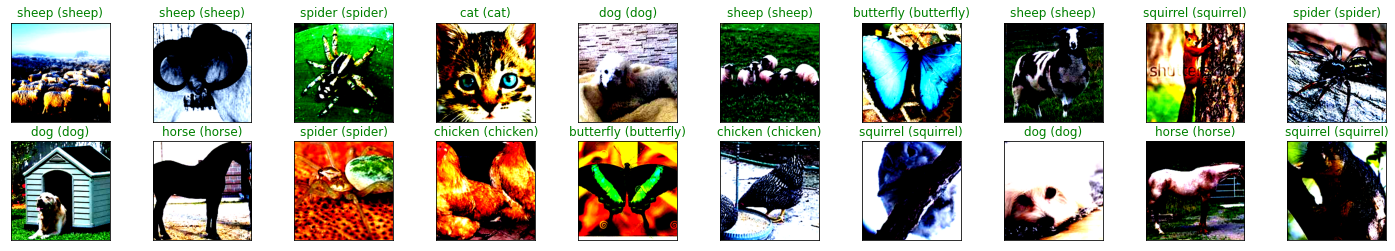

In [ ]:
classes = ["cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora","ragno", "scoiattolo" ]
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
             "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", 
             "ragno": "spider", "scoiattolo": "squirrel" }

disimage = 20
num_classes = 10
# initialize output tensor on CPU: due to GPU memory limits
y_out=torch.zeros(disimage, num_classes)
images = torch.zeros((disimage, 3, 224, 224))
# initialize ground truth on CPU: due to GPU memory limits
y_predictions, y_gt = np.zeros((disimage),dtype="uint8"), np.zeros((disimage),dtype="uint8")
dataiter = iter(test_dl)

for ix in np.arange(disimage):
  image, label = dataiter.next()
  image = image.cuda()
  images[ix] = torch.squeeze(image)
  y_gt[ix] = label
  yy = trained_model(image)
  y_out = torch.softmax(yy, dim=1)
  _, preds_tensor = torch.max(y_out, 1)
  y_predictions[ix] = (np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy()))


fig = plt.figure(figsize=(25, 8))
for idx in np.arange(disimage):
    ax = fig.add_subplot(2, disimage/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].permute(1, 2, 0))
    ax.set_title("{} ({})".format(translate[classes[y_predictions[idx]]], translate[classes[y_gt[idx]]]),
                 color=("green" if y_predictions[idx]==y_gt[idx].item() else "red"))